In [104]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [105]:
data_dir = pathlib.Path("dataset").with_suffix("")
image_count = len(list(data_dir.glob("*/*.jpg")))
print("Found {} images".format(image_count))


Found 677 images


Test display one of the images

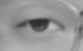

In [106]:
eyes_open = list(data_dir.glob("eyes_open/*"))
PIL.Image.open(str(eyes_open[0]))

In [107]:
batch_size = 30
img_height = 80
img_width = 50

In [108]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 677 files belonging to 2 classes.
Using 542 files for training.


In [109]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size=batch_size
)

Found 677 files belonging to 2 classes.
Using 135 files for validation.


In [110]:
class_names = training_dataset.class_names
print("Using class names with length {}".format(len(class_names)))
print(class_names)

Using class names with length 2
['eyes_closed', 'eyes_open']


2024-05-06 00:42:26.802658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


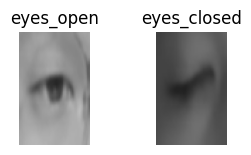

In [111]:
plt.figure(figsize=(5, 5))
for images, labels in training_dataset.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

32 is the amount of images in a single training batch
80 and 50 is the width and height of the image
3 is the array of the pixel which contains tha Red Green and Blue values

In [112]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(30, 80, 50, 3)
(30,)


In [113]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [114]:
#normalize layers which turns 0 ,255 to 0, 1
normalization_layer = layers.Rescaling(1./255)


In [115]:
normalized_dataset = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.114289224 0.74690205


In [116]:
classes_amount = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(classes_amount)
])

In [117]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [118]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 80, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 80, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 40, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 40, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 20, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 10, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,490 (1.97 MB)

 Trainable params: 515,490 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
epochs = 20
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = epochs
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5710 - loss: 0.6569 - val_accuracy: 0.9778 - val_loss: 0.4488
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9155 - loss: 0.3488 - val_accuracy: 0.9778 - val_loss: 0.0954
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9721 - loss: 0.1161 - val_accuracy: 0.9926 - val_loss: 0.0442
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9790 - loss: 0.0648 - val_accuracy: 0.9926 - val_loss: 0.0397
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9818 - loss: 0.0517 - val_accuracy: 0.9926 - val_loss: 0.0385
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9926 - loss: 0.0329 - val_accuracy: 0.9926 - val_loss: 0.0357
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9747 - loss: 0.0681 - val_accuracy: 0.9926 - val_loss: 0.0327
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9796 - loss: 0.0567 - val_accuracy: 0.9926 - v

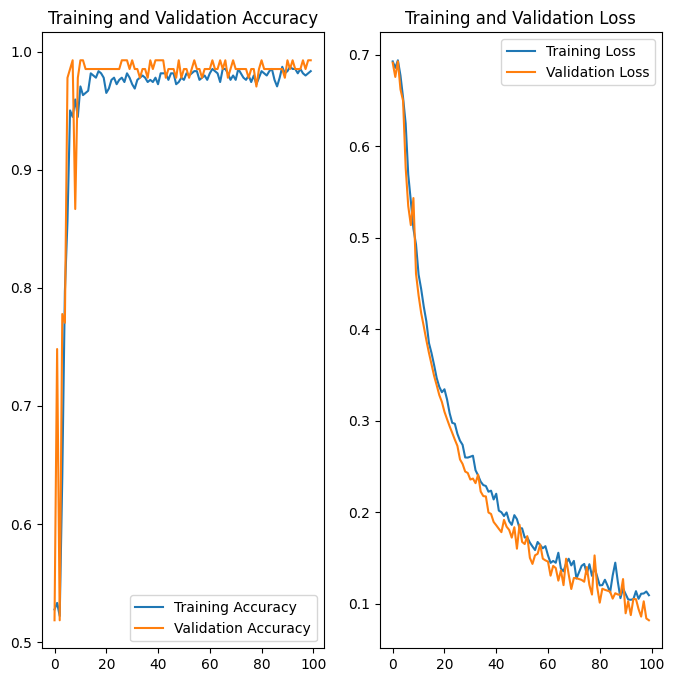

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [121]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-06 00:42:34.668025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


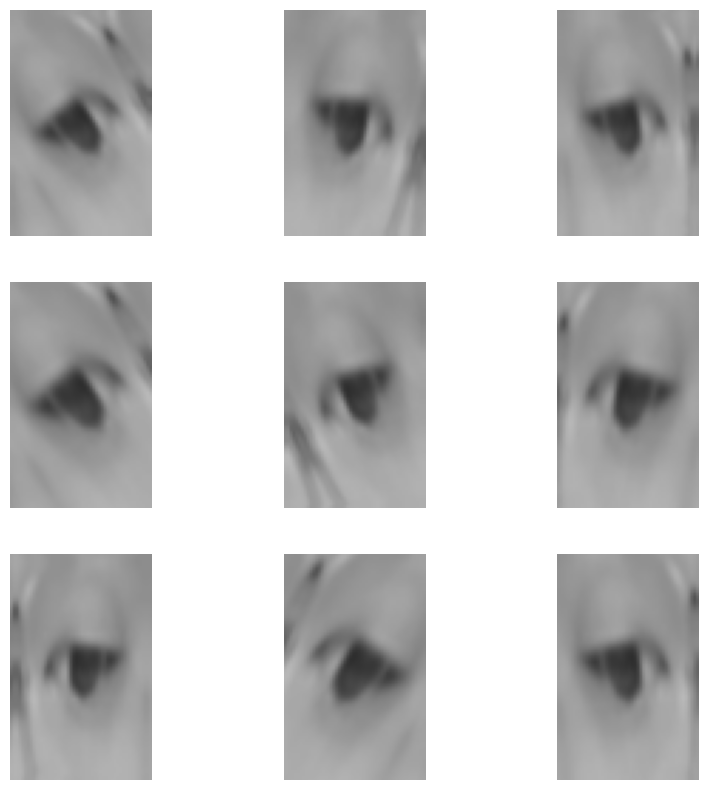

In [122]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [140]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1028, activation='softmax'),
  layers.Dense(classes_amount, name="outputs")
])

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [142]:
epochs = 100
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5035 - loss: 0.6929 - val_accuracy: 0.5185 - val_loss: 0.6911
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5084 - loss: 0.6890 - val_accuracy: 0.7481 - val_loss: 0.6756
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5951 - loss: 0.6859 - val_accuracy: 0.5185 - val_loss: 0.6927
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5741 - loss: 0.6835 - val_accuracy: 0.7778 - val_loss: 0.6620
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7530 - loss: 0.6619 - val_accuracy: 0.7704 - val_loss: 0.6496
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8313 - loss: 0.6361 - val_accuracy: 0.9778 - val_loss: 0.5767
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9469 - loss: 0.5787 - val_accuracy: 0.9852 - val_loss: 0.5344
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9615 - loss: 0.5404 - val_accuracy: 0.

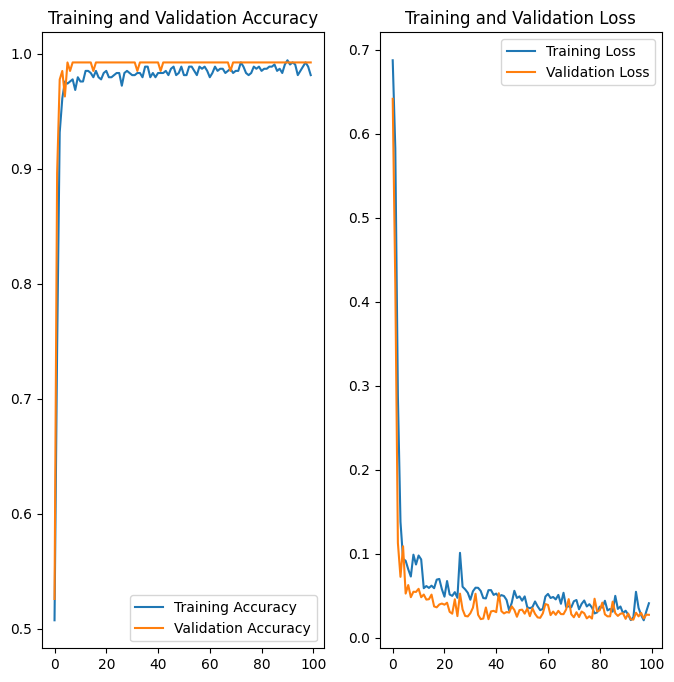

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [175]:
img = tf.keras.utils.load_img(
    "images-3.jpeg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
This image most likely belongs to eyes_open with a 94.70 percent confidence.
